In [133]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time

In [134]:
def tails(x):
    return 1-x
def window(theta0,width = 0.1):
    return lambda theta: np.abs((theta - theta0 + np.pi) % (2*np.pi) - np.pi) < width/2
def projectBasis(someAxis, theta, r = 0.8, theta_width = 0.2, r_width = 0.6):
    someAxis.add_patch(Rectangle((theta - 0.5*theta_width, r - 0.5*r_width), theta_width, r_width,alpha=1,fill=None,linewidth=3))

In [135]:
class Singlet:
    def __init__(self, N = 1000,RPM = 1):
        theta = np.linspace(0,2*np.pi,N)
        r = np.linspace(.6,1,2)
        self.rg, self.tg = np.meshgrid(r,theta)
        self.epoch = time.time() # time t = 0
        self.Afunc = lambda theta: np.cos(theta)**2
        self.Bfunc = lambda theta: np.cos(theta)**2
        self.ATfunc = lambda theta: 1-np.cos(theta)**2
        self.BTfunc = lambda theta: 1-np.cos(theta)**2
        self.theta0 = 0
        self.RPM = RPM
        self.collapsedState = None # None if pre-collapse, True if collapsed to heads, False if collapsed to tails.
        self.figure = None
        self.alice_pol = None
        self.bob_pol = None
        self.transmitted = [None, None] # True, False for transmit/reflect. TODO: implement coin game. Get 85%.
        
    def measure_Alice(self,polarizer_angle):
        # Draws the slit that determines superposition collapse
        # And draws the complementary slit

        projectBasis(self.figure.get_axes()[0],polarizer_angle)
        projectBasis(self.figure.get_axes()[0],polarizer_angle + np.pi/2)
        if self.collapsedState is None:
            projectBasis(self.figure.get_axes()[2],polarizer_angle)
            projectBasis(self.figure.get_axes()[2],polarizer_angle + np.pi/2)
        self.alice_pol = polarizer_angle
 
    def measure_Bob(self,polarizer_angle):
        # Draws the slit that determines superposition collapse
        projectBasis(self.figure.get_axes()[1],polarizer_angle)
        projectBasis(self.figure.get_axes()[1],polarizer_angle + np.pi/2)
        if self.collapsedState is None:
            projectBasis(self.figure.get_axes()[3],polarizer_angle)
            projectBasis(self.figure.get_axes()[3],polarizer_angle + np.pi/2)
        self.bob_pol = polarizer_angle
        
    def collapse_Alice(self):
        # Redefines underlying probability functions Afunc & Bfunc to reflect superposition collapse
        # Probability of transmission through beamsplitter is Afunc(polarizer_angle)
        
        # if we haven't chosen a universe to land in, choose one now. Stop spinning on opposite side.
        if self.collapsedState is None:
            self.Bfunc  = lambda theta: np.cos(theta - photon_angle)**2 # Fix Bob's polarization correlation to match Alice 
            self.BTfunc = lambda theta: np.cos(theta - photon_angle)**2 # Fix Bob's polarization correlation to match Alice

            self.collapsedState = np.random.uniform() < 0.5
            if self.collapsedState is False:
                self.figure.delaxes(self.figure.axes[1])
                self.figure.delaxes(self.figure.axes[0])

            if self.collapsedState is True:
                self.figure.delaxes(self.figure.axes[3])
                self.figure.delaxes(self.figure.axes[2])
        print('Heads universe?',self.collapsedState)
                
                
        # Take care of Alice's circle
        if self.collapsedState is True: # Heads universe
            transmitted = (np.random.uniform() < self.Afunc(self.alice_pol) ) 
            #if transmitted, take theta, not theta'
            photon_angle = self.alice_pol + transmitted * np.pi/2
            self.Afunc  = window(photon_angle,width = 0.2)
        if self.collapsedState is False: # Tails universe
            transmitted = (np.random.uniform() < self.ATfunc(self.alice_pol) ) 
            photon_angle = self.alice_pol + transmitted * np.pi/2
            self.ATfunc = window(photon_angle,width = 0.2)
        return transmitted

    def collapse_Bob(self):
        # Redefines underlying probability functions Afunc & Bfunc to reflect superposition collapse
        # Probability of transmission through beamsplitter is Afunc(polarizer_angle)
        
        # if we haven't chosen a universe to land in, choose one now. Stop spinning on opposite side.
        if self.collapsedState is None:
            self.Afunc  = lambda theta: np.cos(theta - photon_angle)**2 # Fix A's polarization correlation to match Alice 
            self.ATfunc = lambda theta: np.cos(theta - photon_angle)**2 # Fix A's polarization correlation to match Alice

            self.collapsedState = np.random.uniform() < 0.5
            if self.collapsedState is False:
                self.figure.delaxes(self.figure.axes[1])
                self.figure.delaxes(self.figure.axes[0])

            if self.collapsedState is True:
                self.figure.delaxes(self.figure.axes[3])
                self.figure.delaxes(self.figure.axes[2])
        print('Heads universe?',self.collapsedState)
                
                
        #  Collapse B's circle
        if self.collapsedState is True: # Heads universe
            transmitted = (np.random.uniform() < self.Bfunc(self.bob_pol) ) 
            print(self.Bfunc(self.bob_pol))
            #if transmitted, take theta, not theta'
            photon_angle = self.bob_pol + transmitted * np.pi/2
            self.Bfunc  = window(photon_angle,width = 0.2)
        if self.collapsedState is False: # Tails universe
            transmitted = (np.random.uniform() < self.BTfunc(self.alice_pol) ) 
            photon_angle = self.bob_pol + transmitted * np.pi/2
            self.BTfunc = window(photon_angle,width = 0.2)
        
        return transmitted

    def plotState(self):
        # Initializes figure with a bunch of commands from scratch.
        if self.figure == None:
            # make a new figure
            fig = plt.figure(figsize=(8,8))
        else:
            # draw on top of the previous
            fig = self.figure
        theta0 =(((time.time() - self.epoch) * self.RPM / 60) %1) * 2*np.pi # some angle that varies slowly in time.
        print('theta0:',theta0* 180/np.pi)
        
        # figure out where we're pointing
        if self.collapsedState is not False: #collapsed to Heads or uncollapsed
            Aax = fig.add_subplot(221, polar=True)
            Aax.pcolormesh(self.tg, self.rg,self.Afunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
            Aax.set_theta_zero_location('N', 0)
            Aax.text(0,0,"A Heads",fontsize=18,horizontalalignment='center',verticalalignment='center')


            Bax = fig.add_subplot(222, polar=True)
            Bax.pcolormesh(self.tg, self.rg,self.Bfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
            Bax.set_theta_zero_location('N', 0)
            Bax.text(0,0,"B Heads",fontsize=18,horizontalalignment='center',verticalalignment='center')
        if self.collapsedState is not True:
            AaxT = fig.add_subplot(223, polar=True)
            AaxT.pcolormesh(self.tg, self.rg,self.ATfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
            AaxT.set_theta_zero_location('N', 0)
            AaxT.text(0,0,"A Tails",fontsize=18,horizontalalignment='center',verticalalignment='center')

            BaxT = fig.add_subplot(224, polar=True)
            BaxT.pcolormesh(self.tg, self.rg,self.BTfunc(self.tg),cmap='jet')  #plot the colormesh on axis with colormap
            BaxT.set_theta_zero_location('N', 0)
            BaxT.text(0,0,"B Tails",fontsize=18,horizontalalignment='center',verticalalignment='center')
        self.figure = fig

# The disks start spinning up clockwise as a function of time.

These disks represent the quantum state 

$$|\Phi^{(+)}\rangle = (|HH\rangle + |VV\rangle)/\sqrt(2)$$

This state has the property that when we measure it in the same basis on both sides, you get the same result. We can depict this by making the color schemes for the heads side and tails side are synchronized.

This property is evident in the $\{H,V\}$ basis, but I'll write out a quick proof.

Let's say we project Alice's photon onto the basis $\{ |\theta \rangle,|\theta'\rangle \}$ where $\theta$ is some angle between 0 and 90 degrees, and $\theta'$ is its complement. For both photons, $|H\rangle = \cos(\theta) |\theta\rangle - \sin(\theta)|\theta'\rangle$ and $|V\rangle = \sin(\theta)\rangle + \cos(\theta)|\theta'\rangle$. From here on, I'll write $C = \cos\theta$ and $S = \sin\theta$ for brevity.


We can write the state 
\begin{align}
|\Phi^{(+)}\rangle &= \dfrac{1}{\sqrt2}|HH\rangle + \dfrac{1}{\sqrt2}|VV\rangle \\
&= \dfrac{1}{\sqrt2}(C |\theta\rangle - S|\theta'\rangle)(C |\theta\rangle - S|\theta'\rangle) + \dfrac{1}{\sqrt2}(S\rangle + C|\theta'\rangle)(S\rangle + C|\theta'\rangle) \\
&= \dfrac{1}{\sqrt2} [C^2 |\theta\theta\rangle - SC|\theta'\theta\rangle - CS|\theta\theta'\rangle + S^2|\theta'\theta'\rangle] \\
&+ \dfrac{1}{\sqrt2} [S^2 |\theta\theta\rangle + CS|\theta'\theta\rangle + SC|\theta\theta'\rangle + C^2|\theta'\theta'\rangle] \\
&= \dfrac{1}{\sqrt2}|\theta\theta\rangle + \dfrac{1}{\sqrt2}|\theta'\theta'\rangle
\end{align}

There's something really cool going on here. Note that if you had the HH term (second line) by itself or the VV term (third line) by itself, the middle two terms would NOT cancel out! You need both terms (HH and VV) to make the middle terms cancel out (or destructively interfere). While it is the case that $$|HH\rangle + |VV\rangle = |\theta \theta \rangle + |\theta'\theta'\rangle,$$  
it is NOT the case that $|HH\rangle = |\theta\theta\rangle$ and $|VV\rangle = |\theta'\theta'\rangle$.


The disks start out at $\theta_0$ = 0, and spin at a predetermined rate.

theta0: 0.002891063690185547


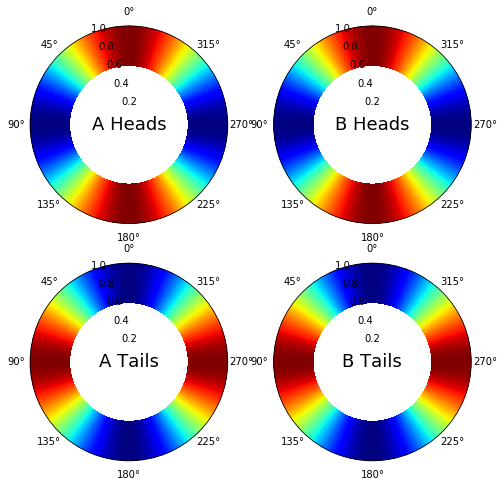

In [136]:
psi = Singlet()
psi.plotState()

We choose to measure Alice's photon in the basis tilted off axis by 22.5 degrees. We haven't collapsed the wavefunction, but this is normal. In real life, you have to set up your experiment and fix your slit before running the photon through!

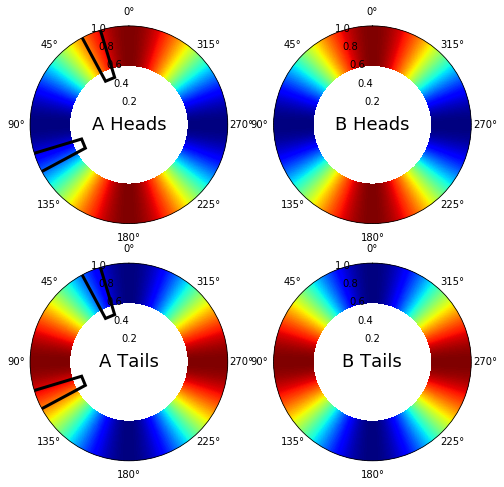

In [137]:
psi.measure_Alice(22.5 * np.pi/180)
psi.figure

Let's say we collapse the wavefunction via Alice. We could have done the same through Bob, but the key point is that there's only one wavefunction, and measuring either side collapses the other instantaneously (in this nonlocal, realist visualization of how reality behaves).

At this point, two things happen.

First, the wavefunction is flipping over and over randomly (not shown), so there's a 50 percent chance that we enter the ''heads'' universe (represented by the top two disks) and a 50 percent chance of entering the ''tails'' universe (bottom two disks).

Second, the wavefunction will collapse into one of the two slices marked out by the slits. The photon being measured collapses into one of the two detector slits. The redder the wavefunction is in that slice, the more likely the photon will go into that slit and not the other slice.

In [1]:
psi.collapse_Alice()
psi.plotState()
psi.figure

NameError: name 'psi' is not defined

We show that Alice's photon got measured because the pretty wavefunction turns into black, except for the measuring device where the photon ended up (white). Note that Bob's side still is a colorful rainbow because the photon hasn't hit the detector slits. But, the rainbow has stopped spinning.
Note: Here, I didn't do black and white but left it as blue and dark red respectively.

theta0: 6.4901061058044425


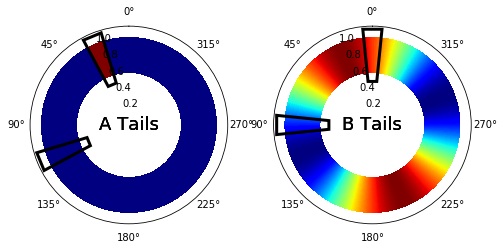

In [139]:
psi.measure_Bob(polarizer_angle=0 * np.pi/180)
psi.plotState()
psi.figure

When Bob's photon hit the detector slits, it can go into one slit or the other in the same way Alice's had the same choice. The wavefunction has finished collapsing.

Now in real life, there's no time ordering like this because of relativity. In a world where we could somehow visualize wavefunctions, an observer moving towards Bob would see Bob's wavefunction turn to black and white first, whereas an observer moving towards Alice would see Alice's wavefunction turn to black and white first. A stationary observer would see both wavefunctions turn to black and white simultaneously. But in the end, the result is the same, because the wavefunction isn't observable and what's observable is simply a detector click: a white strip on an otherwise dark circle.

Heads universe? False
theta0: 7.88667869567871


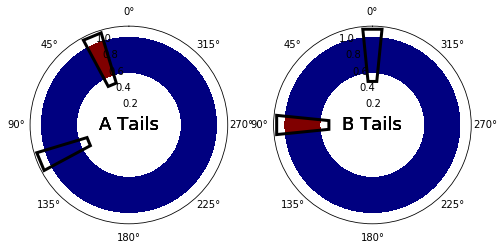

In [140]:
psi.collapse_Bob()
psi.plotState()
psi.figure